# ◆Forex forecast USD／JPY
### 目的：為替予測
### 米ドル円の日足にて、売買予測を行う。
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 視覚化

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰とSVMを利用）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「usdjpy_d.csv」

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 1000 # ※1以上の場合有効
train_size = 0.8

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# ============================================================================
# 学習曲線を作成
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 関数：傾きを算出
# ============================================================================
def get_tilt(close):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length):
        if i < 1:
            tilt[i] = 0
        else :
            a = pd.Series(close)[i:i+1].values - pd.Series(close)[i-1:i].values
            tilt[i] = a/1
    return tilt

# ============================================================================
# 関数：get_rsi
# ============================================================================
def get_rsi(close, period):
    
    diff = close.diff()
    # 値上がり幅、値下がり幅をシリーズへ切り分け
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    # 値上がり幅/値下がり幅の単純移動平均（period)を処理
    up_sma = up.rolling(window=period, center=False).mean()
    down_sma = down.abs().rolling(window=period, center=False).mean()
    
    # RSIの計算
    rs = up_sma / down_sma
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

# ============================================================================
# 関数：get_rci
# ============================================================================
def get_rci(close, period):
    
    rank_period = np.arange(period, 0, -1)
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        if i < period - 1:
            rci[i] = 0
        else :
            #価格順位取得             
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            #rciを取得(int型で取得)
            rci[i] = np.int32((1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100)
            
    return rci

# ============================================================================
# 関数：get_bb
# ============================================================================
def get_bb(close, sigma):
    
    # ±１σの中での値動きになる確率は68.3%
    # ±2σの中での値動きになる確率は95.5%
    mean = close.rolling(window=21).mean()
    std = close.rolling(window=21).std()
    upper = mean + (std * sigma)
    lower = mean - (std * sigma)

    return upper,lower

# ============================================================================
# 関数：get_momentum
# ============================================================================
def get_momentum(close, period):
    # モメンタム＝当日の終値−（period前の終値）
    return close - close.shift(period)

# ============================================================================
# 関数：get_sma
# ============================================================================
def get_sma(close, period):
    return list(pd.Series(close).rolling(period).mean())

# ============================================================================
# 関数：get_ema
# ============================================================================
def get_ema(close, period):
    return list(pd.Series(close).ewm(span=period).mean())

# 1.データ読込

In [2]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

# column name change
df.rename(columns={'Date' : 'time'}, inplace=True)
df.rename(columns={'Open' : 'open'}, inplace=True)
df.rename(columns={'High' : 'high'}, inplace=True)
df.rename(columns={'Low' : 'low'}, inplace=True)
df.rename(columns={'Close' : 'close'}, inplace=True)

# calc target
df = df.query('time >= "2000-01-01"')


# ---------------------------------------------------------

# sma/ema
df['sma5']= get_sma(df.close,5)
df['sma21']= get_sma(df.close,21)
df['ema10']= get_ema(df.close,10)

# tilt(sma/ema)
df['tilt_sma5']= get_tilt(df.sma5)
df['tilt_sma21']= get_tilt(df.sma21)
df['tilt_ema10']= get_tilt(df.ema10)

# ボリンジャーバンド2σ
df['bb2_up'], df['bb2_low'] = get_bb(df.close, 2)

# モメンタム
df['momentum_5'] = get_momentum(df.close, 5)
df['momentum_10'] = get_momentum(df.close, 10)
df['momentum_21'] = get_momentum(df.close, 21)

# RCI
df['rci9'] = get_rci(df.close,9)
df['rci21'] = get_rci(df.close,21)
df['rci52'] = get_rci(df.close,52)

# tilt(RCI)
df['tilt_rci9'] = get_tilt(df.rci9)
df['tilt_rci21'] = get_tilt(df.rci21)
df['tilt_rci52'] = get_tilt(df.rci52)

# RSI
df['rsi14'] = get_rsi(df.close,14)
df['tilt_rsi14'] = get_tilt(df.rsi14)

# ---------------------------------------------------------

# 当日の差分
df['day_diff'] = df.close - df.open

# ローソク足の特徴
df['candle_up'] = np.where(df.day_diff >= 0,1,0) # 陽線：1／陰線：0
df['candle_length1'] = abs(df.high - df.low) # ローソクの長さ(ヒゲ含む)
df['candle_length2'] = np.where(df.day_diff >= 0,df.close - df.open,df.open - df.close) # ローソクの長さ
df['top_bar'] = np.where(df.day_diff >= 0,df.high - df.close, df.high - df.open) # 上ヒゲの長さ
df['low_bar'] = np.where(df.day_diff >= 0,df.open - df.low, df.close - df.low)   # 下ヒゲの長さ

# ローソクの形を考慮
df['candle_marubouzu'] = np.where((df['top_bar'] == 0) & (df['low_bar'] == 0), 1 , 0)
df['candle_tonbo1'] = np.where((df['top_bar'] >= 0) & (df['low_bar'] == 0), 1 , 0)
df['candle_tonbo2'] = np.where((df['top_bar'] == 0) & (df['low_bar'] >= 0), 1 , 0)
df['candle_juji'] = np.where(df['candle_length2'] < 0.5, 1 , 0)

# 直近数日間のローソク足を考慮する
df['y1_day_diff'] = df.day_diff.shift(+1)
df['y1_candle_length1'] =df.candle_length1.shift(+1)
df['y1_candle_length2'] =df.candle_length2.shift(+1)
df['y1_candle_up'] =df.candle_up.shift(+1)
df['y1_top_bar'] =df.top_bar.shift(+1)
df['y1_low_bar'] =df.low_bar.shift(+1)

df['y2_day_diff'] = df.day_diff.shift(+2)
df['y2_candle_length1'] =df.candle_length1.shift(+2)
df['y2_candle_length2'] =df.candle_length2.shift(+2)
df['y2_candle_up'] =df.candle_up.shift(+2)
df['y2_top_bar'] =df.top_bar.shift(+2)
df['y2_low_bar'] =df.low_bar.shift(+2)

df['y3_day_diff'] = df.day_diff.shift(+3)
df['y3_candle_length1'] =df.candle_length1.shift(+3)
df['y3_candle_length2'] =df.candle_length2.shift(+3)
df['y3_candle_up'] =df.candle_up.shift(+3)
df['y3_top_bar'] =df.top_bar.shift(+3)
df['y3_low_bar'] =df.low_bar.shift(+3)

df['y4_day_diff'] = df.day_diff.shift(+4)
df['y4_candle_length1'] =df.candle_length1.shift(+4)
df['y4_candle_length2'] =df.candle_length2.shift(+4)
df['y4_candle_up'] =df.candle_up.shift(+4)
df['y4_top_bar'] =df.top_bar.shift(+4)
df['y4_low_bar'] =df.low_bar.shift(+4)

df['y5_day_diff'] = df.day_diff.shift(+5)
df['y5_candle_length1'] =df.candle_length1.shift(+5)
df['y5_candle_length2'] =df.candle_length2.shift(+5)
df['y5_candle_up'] =df.candle_up.shift(+5)
df['y5_top_bar'] =df.top_bar.shift(+5)
df['y5_low_bar'] =df.low_bar.shift(+5)

# test target
df = df.query('time >= "2001-01-01"')

printmd('▼ size')
display(df.shape)

printmd('▼ 直近10行表示')
display(df.tail(10))

display(df.query('candle_marubouzu == 1').head(2))



**▼ size**

(4941, 64)



**▼ 直近10行表示**

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb2_up,bb2_low,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_diff,candle_up,candle_length1,candle_length2,top_bar,low_bar,candle_marubouzu,candle_tonbo1,candle_tonbo2,candle_juji,y1_day_diff,y1_candle_length1,y1_candle_length2,y1_candle_up,y1_top_bar,y1_low_bar,y2_day_diff,y2_candle_length1,y2_candle_length2,y2_candle_up,y2_top_bar,y2_low_bar,y3_day_diff,y3_candle_length1,y3_candle_length2,y3_candle_up,y3_top_bar,y3_low_bar,y4_day_diff,y4_candle_length1,y4_candle_length2,y4_candle_up,y4_top_bar,y4_low_bar,y5_day_diff,y5_candle_length1,y5_candle_length2,y5_candle_up,y5_top_bar,y5_low_bar
12532,2020-01-06,107.806,108.505,107.774,108.378,108.5020,109.044810,108.791679,-0.2112,-0.022857,-0.091929,110.018898,108.070721,-1.056,-1.006,-0.480,-85.0,-11.0,21.0,-4.0,-17.0,-10.0,33.025240,8.796329,0.572,1,0.731,0.572,0.127,0.032,0,0,0,0,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132,-0.560,0.693,0.560,0.0,0.025,0.108,-0.143,0.201,0.143,0.0,0.015,0.043
12533,2020-01-07,108.378,108.628,108.263,108.458,108.4180,109.030762,108.731010,-0.0840,-0.014048,-0.060669,110.030691,108.030833,-0.420,-1.037,-0.295,-88.0,-28.0,15.0,-3.0,-17.0,-6.0,27.843738,-5.181502,0.080,1,0.365,0.080,0.170,0.115,0,0,0,1,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132,-0.560,0.693,0.560,0.0,0.025,0.108
12534,2020-01-08,108.459,109.244,107.651,109.078,108.5128,109.055429,108.794099,0.0948,0.024667,0.063089,110.031863,108.078994,0.474,-0.323,0.518,-58.0,-35.0,16.0,30.0,-7.0,1.0,43.035144,15.191406,0.619,1,1.593,0.619,0.166,0.808,0,0,0,0,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132
12535,2020-01-09,109.078,109.582,109.013,109.480,108.6990,109.098429,108.918809,0.1862,0.043000,0.124709,110.065865,108.130992,0.931,0.102,0.903,1.0,-36.0,19.0,59.0,-1.0,3.0,48.631518,5.596375,0.402,1,0.569,0.402,0.102,0.065,0,0,0,1,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335
12536,2020-01-10,109.478,109.688,109.437,109.500,108.9788,109.131762,109.024480,0.2798,0.033333,0.105671,110.104236,108.159288,1.399,-0.076,0.700,48.0,-33.0,24.0,47.0,3.0,5.0,51.757576,3.126057,0.022,1,0.251,0.022,0.188,0.041,0,0,0,1,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250
12537,2020-01-13,109.538,109.947,109.534,109.934,109.2900,109.197762,109.189847,0.3112,0.066000,0.165367,110.191730,108.203794,1.556,0.500,1.386,73.0,-27.0,28.0,25.0,6.0,4.0,56.058515,4.300939,0.396,1,0.413,0.396,0.013,0.004,0,0,0,1,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032
12538,2020-01-14,109.935,110.200,109.862,109.988,109.5960,109.221571,109.334966,0.3060,0.023810,0.145119,110.267343,108.175799,1.530,1.110,0.500,90.0,-8.0,32.0,17.0,19.0,4.0,58.191460,2.132945,0.053,1,0.338,0.053,0.212,0.073,0,0,0,1,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115
12539,2020-01-15,109.987,110.001,109.790,109.887,109.7578,109.247952,109.435336,0.1618,0.026381,0.100370,110.332753,108.163152,0.809,1.283,0.554,95.0,2.0,32.0,5.0,10.0,0.0,56.951653,-1.239807,-0.100,0,0.211,0.100,0.014,0.097,0,0,0,1,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808
12540,

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb2_up,bb2_low,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_diff,candle_up,candle_length1,candle_length2,top_bar,low_bar,candle_marubouzu,candle_tonbo1,candle_tonbo2,candle_juji,y1_day_diff,y1_candle_length1,y1_candle_length2,y1_candle_up,y1_top_bar,y1_low_bar,y2_day_diff,y2_candle_length1,y2_candle_length2,y2_candle_up,y2_top_bar,y2_low_bar,y3_day_diff,y3_candle_length1,y3_candle_length2,y3_candle_up,y3_top_bar,y3_low_bar,y4_day_diff,y4_candle_length1,y4_candle_length2,y4_candle_up,y4_top_bar,y4_low_bar,y5_day_diff,y5_candle_length1,y5_candle_length2,y5_candle_up,y5_top_bar,y5_low_bar
7827,2001-11-13,120.58,121.72,120.58,121.72,120.750,121.695714,121.208638,0.104,0.037143,0.113636,123.353973,120.037455,0.52,-0.29,0.78,-66.0,-40.0,67.0,25.0,-9.0,0.0,38.817006,12.372561,1.14,1,1.14,1.14,0.0,0.0,1,1,1,0,-0.04,1.00,0.04,0.0,0.39,0.57,0.22,0.45,0.22,1.0,0.15,0.08,-0.94,1.47,0.94,0.0,0.25,0.28,-0.27,0.48,0.27,0.0,0.05,0.16,-0.44,0.71,0.44,0.0,0.13,0.14
7883,2002-02-01,134.83,134.83,133.04,133.04,133.564,132.885238,133.513698,-0.276,0.058571,-0.105266,135.202276,130.568200,-1.38,0.44,1.23,-38.0,76.0,96.0,-56.0,-3.0,-1.0,55.050505,-11.820661,-1.79,0,1.79,1.79,0.0,0.0,1,1,1,0,1.64,2.18,1.64,1.0,0.00,0.54,-0.74,1.24,0.74,0.0,0.00,0.50,-0.23,0.69,0.23,0.0,0.13,0.33,-1.44,1.69,1.44,0.0,0.00,0.25,-0.48,0.81,0.48,0.0,0.08,0.25


# 2. データ可視化

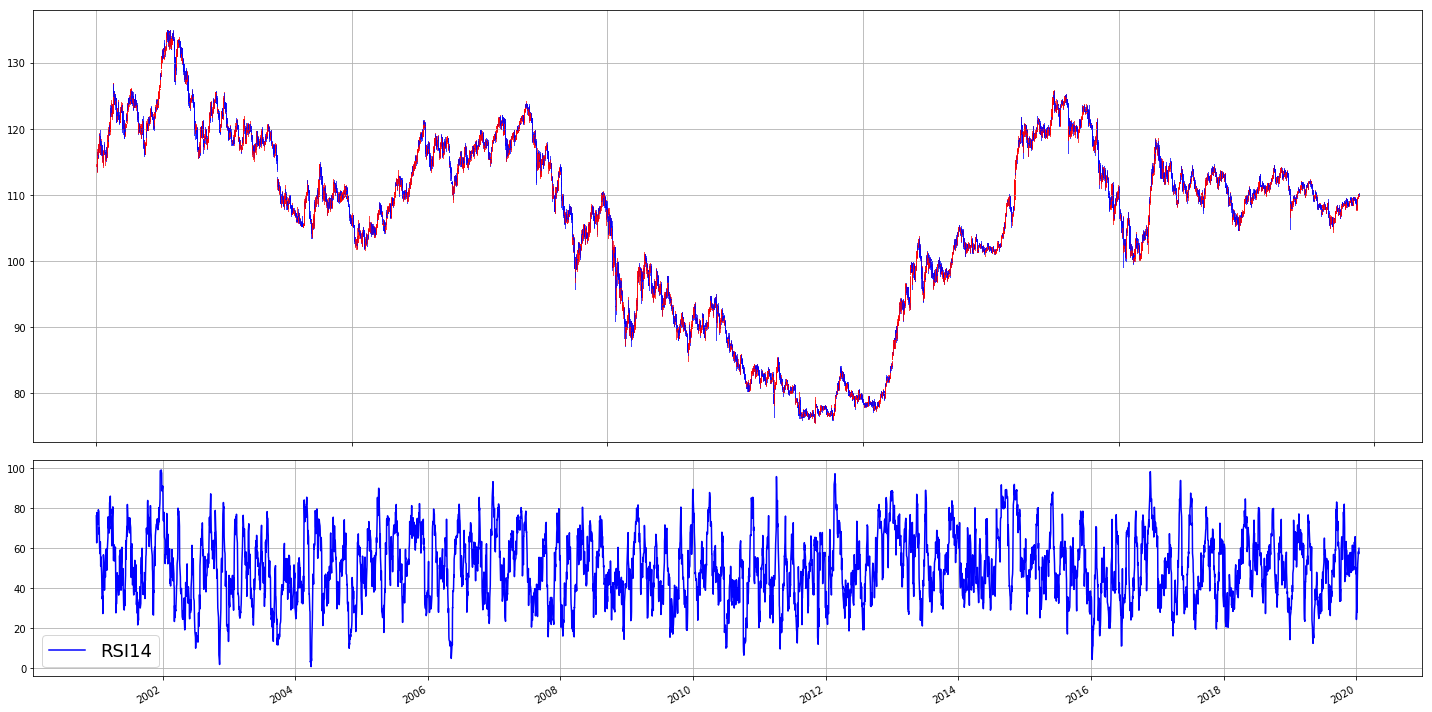

In [3]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.open, highs=df.high, lows=df.low, closes=df.close, 
                              width=1,colorup='r', colordown='b')

# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df.time, df.rsi14, color='b', antialiased=True, label='RSI14')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()

### 翌日終値が当日終値よりも上昇するかを予測する

In [4]:
# 翌日終値が当日終値よりも上昇するかを予測
df['close_1'] = df.close.shift(-1)
df['diff'] = df['close_1'] - df['close']
df = df[:-1]

# 30pips 上昇したら1、30pips下落したら2、それ以外は0
#df['target'] = np.where(df['diff'] >= 0.3,1,np.where(df['diff'] < -0.3,2, 0))
# 5pips 上昇したら1、それ以外は0
df['target'] = np.where(df['diff'] >= 0.01,1,0)

display(df.tail(5))

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb2_up,bb2_low,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_diff,candle_up,candle_length1,candle_length2,top_bar,low_bar,candle_marubouzu,candle_tonbo1,candle_tonbo2,candle_juji,y1_day_diff,y1_candle_length1,y1_candle_length2,y1_candle_up,y1_top_bar,y1_low_bar,y2_day_diff,y2_candle_length1,y2_candle_length2,y2_candle_up,y2_top_bar,y2_low_bar,y3_day_diff,y3_candle_length1,y3_candle_length2,y3_candle_up,y3_top_bar,y3_low_bar,y4_day_diff,y4_candle_length1,y4_candle_length2,y4_candle_up,y4_top_bar,y4_low_bar,y5_day_diff,y5_candle_length1,y5_candle_length2,y5_candle_up,y5_top_bar,y5_low_bar,close_1,diff,target
12536,2020-01-10,109.478,109.688,109.437,109.500,108.9788,109.131762,109.024480,0.2798,0.033333,0.105671,110.104236,108.159288,1.399,-0.076,0.700,48.0,-33.0,24.0,47.0,3.0,5.0,51.757576,3.126057,0.022,1,0.251,0.022,0.188,0.041,0,0,0,1,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,109.934,0.434,1
12537,2020-01-13,109.538,109.947,109.534,109.934,109.2900,109.197762,109.189847,0.3112,0.066000,0.165367,110.191730,108.203794,1.556,0.500,1.386,73.0,-27.0,28.0,25.0,6.0,4.0,56.058515,4.300939,0.396,1,0.413,0.396,0.013,0.004,0,0,0,1,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,109.988,0.054,1
12538,2020-01-14,109.935,110.200,109.862,109.988,109.5960,109.221571,109.334966,0.3060,0.023810,0.145119,110.267343,108.175799,1.530,1.110,0.500,90.0,-8.0,32.0,17.0,19.0,4.0,58.191460,2.132945,0.053,1,0.338,0.053,0.212,0.073,0,0,0,1,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,109.887,-0.101,0
12539,2020-01-15,109.987,110.001,109.790,109.887,109.7578,109.247952,109.435336,0.1618,0.026381,0.100370,110.332753,108.163152,0.809,1.283,0.554,95.0,2.0,32.0,5.0,10.0,0.0,56.951653,-1.239807,-0.100,0,0.211,0.100,0.014,0.097,0,0,0,1,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,110.178,0.291,1
12540,2020-01-16,109.887,110.186,109.856,110.178,109.8974,109.274762,109.570366,0.1396,0.026810,0.135030,110.423599,108.125925,0.698,1.629,0.563,95.0,22.0,33.0,0.0,20.0,1.0,58.018114,1.066461,0.291,1,0.330,0.291,0.008,0.031,0,0,0,1,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,110.149,-0.029,0




**▼ 目的変数 targetの種類（%）**

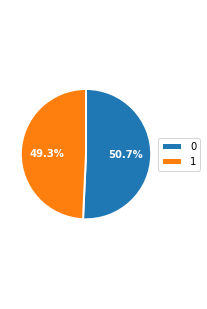

,target
0,2506
1,2434


In [5]:
printmd('▼ 目的変数 targetの種類（%）')
per_state = round(df['target'].value_counts() / len(df['target']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

display(pd.DataFrame(df['target'].value_counts(),columns=['target']))

In [6]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
X_all_df = df.drop(['time','close_1','diff','target'], axis=1)

# 標準化項目リスト
enc_norm_col = ['open','high','low','close',
                'sma5','sma21','ema10',
                'rci9','rci21','rci52',
                'tilt_rci9','tilt_rci21','tilt_rci52',
                'tilt_sma5','tilt_sma21',
                'tilt_ema10',
                'rsi14',
                'tilt_rsi14',
                'bb2_up','bb2_low',
                'momentum_5','momentum_10','momentum_21',
                'day_diff','candle_length1','candle_length2','top_bar','low_bar',
                'y1_day_diff','y1_candle_length1','y1_candle_length2','y1_top_bar','y1_low_bar',
                'y2_day_diff','y2_candle_length1','y2_candle_length2','y2_top_bar','y2_low_bar',
                'y3_day_diff','y3_candle_length1','y3_candle_length2','y3_top_bar','y3_low_bar',
                'y4_day_diff','y4_candle_length1','y4_candle_length2','y4_top_bar','y4_low_bar',
                'y5_day_diff','y5_candle_length1','y5_candle_length2','y5_top_bar','y5_low_bar',
               ]

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns
    
# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['target'].values

X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

X_test = X_all[split_row+1:,:]
y_test = y_all[split_row+1:]

# -------------------------------------------------
printmd('▼標準化')
for col_name,col_idx in dic_norm_col.items():
    
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
# 直近の5行を表示
display(X_all_df.tail(10))



**▼標準化**

,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb2_up,bb2_low,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_diff,candle_up,candle_length1,candle_length2,top_bar,low_bar,candle_marubouzu,candle_tonbo1,candle_tonbo2,candle_juji,y1_day_diff,y1_candle_length1,y1_candle_length2,y1_candle_up,y1_top_bar,y1_low_bar,y2_day_diff,y2_candle_length1,y2_candle_length2,y2_candle_up,y2_top_bar,y2_low_bar,y3_day_diff,y3_candle_length1,y3_candle_length2,y3_candle_up,y3_top_bar,y3_low_bar,y4_day_diff,y4_candle_length1,y4_candle_length2,y4_candle_up,y4_top_bar,y4_low_bar,y5_day_diff,y5_candle_length1,y5_candle_length2,y5_candle_up,y5_top_bar,y5_low_bar
12531,108.547,108.631,107.851,108.101,108.7132,109.067667,108.883608,-0.2950,-0.025524,-0.173913,109.997562,108.137771,-1.475,-1.474,-0.536,-81.0,6.0,31.0,-20.0,-20.0,-9.0,24.228911,-25.786797,-0.446,0,0.780,0.446,0.084,0.250,0,0,0,1,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132,-0.560,0.693,0.560,0.0,0.025,0.108,-0.143,0.201,0.143,0.0,0.015,0.043,0.186,0.320,0.186,1.0,0.109,0.025
12532,107.806,108.505,107.774,108.378,108.5020,109.044810,108.791679,-0.2112,-0.022857,-0.091929,110.018898,108.070721,-1.056,-1.006,-0.480,-85.0,-11.0,21.0,-4.0,-17.0,-10.0,33.025240,8.796329,0.572,1,0.731,0.572,0.127,0.032,0,0,0,0,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132,-0.560,0.693,0.560,0.0,0.025,0.108,-0.143,0.201,0.143,0.0,0.015,0.043
12533,108.378,108.628,108.263,108.458,108.4180,109.030762,108.731010,-0.0840,-0.014048,-0.060669,110.030691,108.030833,-0.420,-1.037,-0.295,-88.0,-28.0,15.0,-3.0,-17.0,-6.0,27.843738,-5.181502,0.080,1,0.365,0.080,0.170,0.115,0,0,0,1,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132,-0.560,0.693,0.560,0.0,0.025,0.108
12534,108.459,109.244,107.651,109.078,108.5128,109.055429,108.794099,0.0948,0.024667,0.063089,110.031863,108.078994,0.474,-0.323,0.518,-58.0,-35.0,16.0,30.0,-7.0,1.0,43.035144,15.191406,0.619,1,1.593,0.619,0.166,0.808,0,0,0,0,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,-0.269,0.407,0.269,0.0,0.006,0.132
12535,109.078,109.582,109.013,109.480,108.6990,109.098429,108.918809,0.1862,0.043000,0.124709,110.065865,108.130992,0.931,0.102,0.903,1.0,-36.0,19.0,59.0,-1.0,3.0,48.631518,5.596375,0.402,1,0.569,0.402,0.102,0.065,0,0,0,1,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335
12536,109.478,109.688,109.437,109.500,108.9788,109.131762,109.024480,0.2798,0.033333,0.105671,110.104236,108.159288,1.399,-0.076,0.700,48.0,-33.0,24.0,47.0,3.0,5.0,51.757576,3.126057,0.022,1,0.251,0.022,0.188,0.041,0,0,0,1,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250
12537,109.538,109.947,109.534,109.934,109.2900,109.197762,109.189847,0.3112,0.066000,0.165367,110.191730,108.203794,1.556,0.500,1.386,73.0,-27.0,28.0,25.0,6.0,4.0,56.058515,4.300939,0.396,1,0.413,0.396,0.013,0.004,0,0,0,1,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032
12538,109.935,110.200,109.862,109.988,109.5960,109.221571,109.334966,0.3060,0.023810,0.145119,110.267343,108.175799,1.530,1.110,0.500,90.0,-8.0,32.0,17.0,19.0,4.0,58.191460,2.132945,0.053,1,0.338,0.053,0.212,0.073,0,0,0,1,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115
12539,109.987,110.001,109.790,109.887,109.7578,109.247952,109.435336,0.1618,0.02638

# モデル構築

Score: 0.503289 (0.011398) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.518725 (0.031143) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.502783 (0.012311) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.489372 (0.012093) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.522267 (0.012010) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.495445 (0.019034) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.521508 (0.011376) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.492662 (0.011671) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
★BestScore: 0.522267 using {'alpha': 0.001, 'penalty': 'none'}


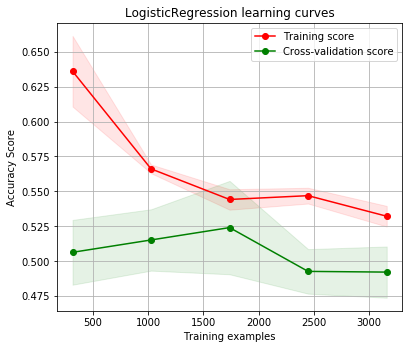

In [7]:
dic_models = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

# ロジスティック回帰
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('LogisticRegression', grid_result) # 辞書に格納
best_lr = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)

# 学習



**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,candle_marubouzu,-2.588088
1,tilt_ema10,-0.999122
2,candle_tonbo1,0.824815
3,bb2_up,0.515318
4,candle_tonbo2,-0.392805
5,momentum_10,0.239171
6,bb2_low,-0.233010
7,tilt_sma5,0.200827
8,momentum_5,0.200827
9,sma21,0.147962




**▼ 重みの大きさを横棒グラフで表示**

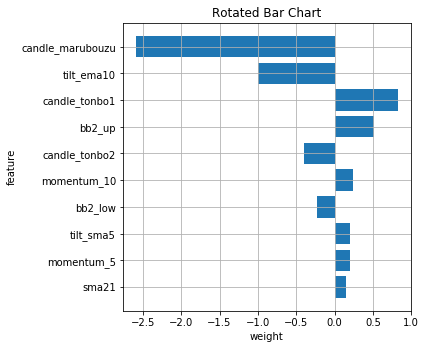



**▼ モデルの評価結果**

正答率（訓練データ） = 53.770%
正答率（テストデータ）= 50.253%
適合率（Precision※精度) = 50.755%
再現率（Recall※検出率) = 67.066%
F1値（F1-score） = 57.782%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,336,165
正解 =翌日上昇する,326,160




**▼ 閾値以上の信頼度でトレードした場合の勝率**

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,pred,actual,max_prob
9,0.269217,0.248208,0.165015,0.170521,0.304539,0.431631,0.349297,-2.954615,-1.495329,-2.887620,0.458902,0.401125,-2.954615,-2.036654,-1.495329,-1.529145,-1.110078,-1.251292,-0.078126,-0.749735,-0.226187,-1.280172,-0.069996,-2.217722,0.0,2.310108,2.185110,-0.332910,1.328560,0.0,0.0,0.0,0.0,-0.889687,0.603822,0.243933,0.0,0.434951,0.537210,-1.464170,0.772854,1.083847,0.0,-1.040612,0.529345,-0.384483,-0.490830,-0.494920,0.0,0.009446,-0.177704,-1.330130,0.026011,0.886448,0.0,-0.932697,-0.836340,0.143981,-0.782136,-0.864008,1.0,-0.548333,0.300702,1,0,0.667013
11,0.158827,0.150493,0.163136,0.150703,0.212945,0.398617,0.285738,-2.312652,-1.753836,-2.180292,0.480260,0.312015,-2.312652,-2.682287,-1.753836,-1.529145,-1.172221,-1.251292,0.001604,-0.185381,0.010105,-1.786744,-1.034540,-0.182999,0.0,-0.325686,-0.789340,0.620271,0.245343,0.0,0.0,0.0,1.0,-0.148280,-0.051917,-0.839865,0.0,3.113658,-1.027680,-2.217659,2.310245,2.185229,0.0,-0.333833,1.329900,-0.889746,0.603892,0.243763,0.0,0.434520,0.538032,-1.465519,0.774128,1.084395,0.0,-1.040240,0.530859,-0.385566,-0.489899,-0.494542,0.0,0.010162,-0.176568,1,1,0.661214
12,0.150726,0.173937,0.178774,0.194223,0.189869,0.382006,0.269169,-1.188352,-1.756202,-1.205976,0.469902,0.289021,-1.188352,-2.018377,-1.756202,-1.390937,-1.156685,-1.251292,0.360390,0.096796,0.010105,-1.496199,0.743481,0.976478,1.0,-0.108945,0.351635,-0.266290,-0.676200,0.0,0.0,0.0,0.0,-0.182869,-0.325601,-0.789303,0.0,0.619336,0.246068,-0.148196,-0.051863,-0.839724,0.0,3.112993,-1.027288,-2.217566,2.310263,2.185004,0.0,-0.333687,1.330598,-0.890868,0.605021,0.244222,0.0,0.434636,0.538949,-1.465723,0.774619,1.084484,0.0,-1.040218,0.531248,1,1,0.611675
24,0.383824,0.380788,0.179244,0.160344,0.336754,0.278246,0.291927,-0.907795,-1.467281,-2.124043,0.311901,0.241945,-0.907795,-0.644615,-1.467281,0.405764,-0.162408,-1.235339,-2.390300,0.096796,0.010105,-0.045772,-3.655263,-5.020918,0.0,5.566737,6.282949,1.066114,-0.142675,0.0,0.0,0.0,0.0,0.238214,-0.461524,-0.727748,1.0,0.409342,-0.000594,0.107479,-0.309013,-0.918866,1.0,-0.226280,1.188388,-0.828092,-0.020614,0.153626,0.0,-1.071165,0.517813,3.300169,2.886135,3.750076,1.0,-0.195259,-0.391394,-0.462291,-0.726997,-0.382383,0.0,-0.307514,-0.653839,1,0,0.789461
27,0.046227,0.084771,0.022654,0.082276,0.144802,0.228097,0.188003,-3.005060,-1.478433,-1.708402,0.279717,0.173468,-3.005060,-1.146994,-1.478433,-1.114522,-0.224550,-1.251292,-0.715967,-0.373499,-0.226187,-0.673664,-0.104387,0.809549,1.0,1.711314,0.107611,1.460711,2.415819,0.0,0.0,0.0,0.0,0.126928,-0.560712,-0.890428,1.0,0.942010,-0.340261,-2.455286,1.744515,2.532571,0.0,-0.682101,-0.279295,-5.020573,5.566878,6.282935,0.0,1.064450,-0.141311,0.237372,-0.461092,-0.727916,1.0,0.409031,0.000968,0.106371,-0.307941,-0.918988,1.0,-0.225533,1.190528,1,1,0.716534
50,0.209302,0.197314,0.090109,0.061655,0.244544,0.243025,0.235511,-2.612557,-0.216307,-2.812040,0.236913,0.248066,-2.612557,-1.737301,-0.216307,-0.761324,0.629906,-0.469563,-1.872054,-2.630917,0.010105,-0.754023,-2.038908,-3.317044,0.0,2.960332,3.792149,0.348666,-0.732785,0.0,0.0,0.0,0.0,-0.915253,0.162989,0.281306,0.0,-0.502341,0.237980,-1.891297,1.468997,1.708183,0.0,-0.661615,0.614253,-0.596513,-0.228170,-0.184937,0.0,-0.057132,-0.117048,1.102357,0.132622,0.536743,1.0,0.403910,-1.014319,1.010514,0.004513,0.402732,1.0,-0.983856,0.045888,1,1,0.638060
53,0.107481,0.080296,0.093063,0.078393,0.115937,0.232703,0.174236,-1.784708,-0.832670,-1.548560,0.247081,0.216593,-1.784708,-1.626156,-0.832670,-1.329511,-0.286693,-0.421702,-0.197721,-1.314090,0.010105,-0.928596,-0.113799,-0.653707,0.0,-0.338543,-0.101238,-0.835124,0.099836,0.0,0.0,0.0,1.0,-0.301674,-0.402747,-0.615631,0.0,0.752503,-0.348348,1.549787,0.451417,1.189368,1.0,-0.523332,-0.780652,-3.316814,2.960484,3.792079,0.0,0.347457,-0

正答率（※閾値指定）=62.338%


In [8]:
# 学習
best_lr.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_all_df.columns)
res_df['weight'] = np.reshape(best_lr.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
printmd('▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
printmd('▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

y_train_pred = best_lr.predict(X_train) # 訓練データ
y_test_pred = best_lr.predict(X_test) # テストデータ


printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])
display(conf_mat)

printmd('▼ 閾値以上の信頼度でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = best_lr.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.60: # n%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
b = a[a['pred'] == 1]
display(b.head(10))
print('正答率（※閾値指定）={:.3f}%'.format(accuracy_score(b['pred'], b['actual']) * 100))